# Generate Fish Classification Dataset

In [1]:
import os
from mylib.models.bboxregressor import Ipv3BboxRegressor, slide_bboxes
from mylib.dataio import TrainDataReader, TestDataReader
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
%matplotlib inline

file_dir_path = os.path.dirname(os.path.abspath('__file__'))

# settings
debug = 1
seed = 7
np.random.seed(seed)
bbox_weights_file = os.path.join(file_dir_path, "ipv3_bbox_regressor_weights_2/ipv3_bbox_regressor_nb_5-184--10.47-19.39.h5")

Using TensorFlow backend.


In [2]:
# load bbox regressor
ipv3_bbox = Ipv3BboxRegressor(bbox_weights_file)

In [3]:
# load train dataset
train_data_reader = TrainDataReader()
images_train, image_names_train, bboxes_train = train_data_reader.load_train_image_bbox_imgname(debug=debug)

Start loading train data!
Finish loading train data!


In [4]:
def IoU(bbox0, bbox1):
    x0, y0, w0, h0, p0 = bbox0
    x1, y1, w1, h1, p1 = bbox1
    
    start_x = min(x0, x1)
    end_x = max(x0 + w0, x1 + w1)
    width = w0 + w1 - (end_x - start_x)
    
    start_y = min(y0, y1)
    end_y = max(y0 + h0, y1+ h1)
    height = h0 + h1 - (end_y - start_y)
    
    if width <= 0 or height <= 0:
        ratio = 0
    else:
        Area = width*height
        Area0 = w0 * h0
        Area1 = w1 * h1
        ratio = Area*1./(Area0 + Area1 - Area)
    return ratio        

In [5]:
bboxes_pre_train = ipv3_bbox.predict_with_slide_bbox(images_train)

In [6]:
def get_bboxes_with_iou_than(bboxes_pre, bboxes_true, iou_threshold=(0.3, 0.5)):

    low_iou = iou_threshold[0]
    high_iou = iou_threshold[1]

    nb_pre = len(bboxes_pre)
    nb_true = len(bboxes_true)
    if nb_pre != nb_true:
        print("Error: nb_pre != nb_true")
    
    bboxes_with_fish = []
    bboxes_without_fish = []
    for i in range(nb_pre):
        bbox_pre = bboxes_pre[i]
        bbox_true = bboxes_true[i]
        
        bbox_fish = []
        bbox_nofish = []
        for bbox_p in bbox_pre:

            is_inter = False
            for bbox_t in bbox_true:
                if IoU(bbox_p, bbox_t) >= high_iou:
                    bbox_fish.append(bbox_p)
                    is_inter = True
                    break
            if not is_inter:
                is_no_inter = True
                for bbox_t in bbox_true:
                    if IoU(bbox_p, bbox_t) >= low_iou:
                        is_no_inter = False
                        continue
                if is_no_inter:
                    bbox_nofish.append(bbox_p)
                
        bboxes_with_fish.append(bbox_fish)
        bboxes_without_fish.append(bbox_nofish)
    
    return bboxes_with_fish, bboxes_without_fish

In [7]:
bboxes_fish, bboxes_nofish = get_bboxes_with_iou_than(bboxes_pre_train, bboxes_train, iou_threshold=(0.3, 0.6))

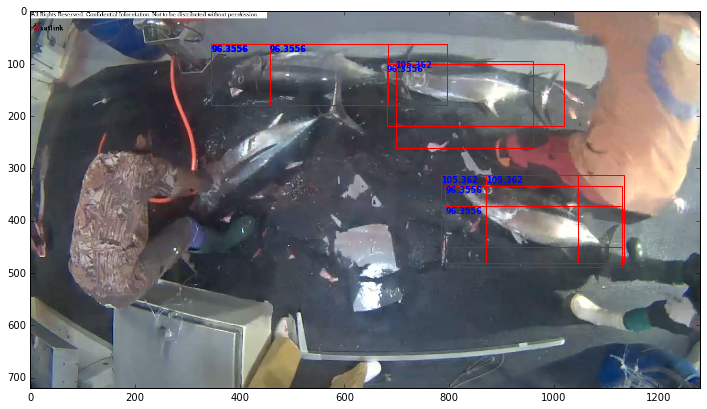

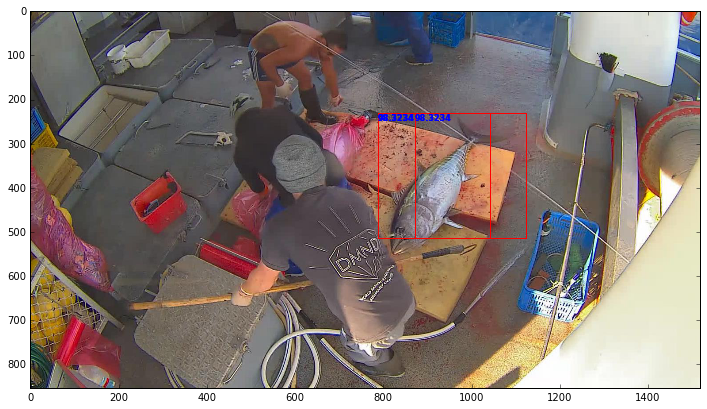

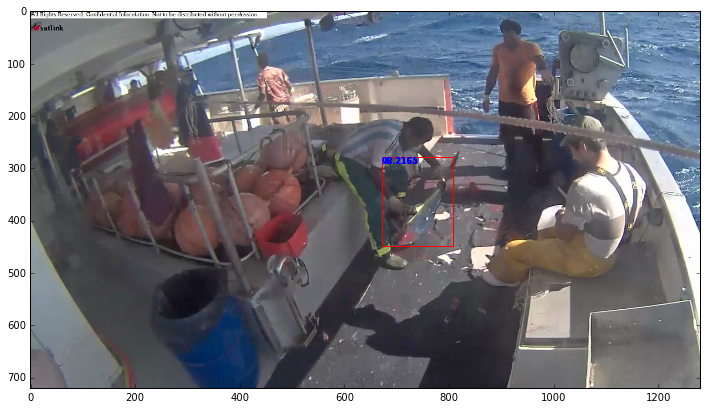

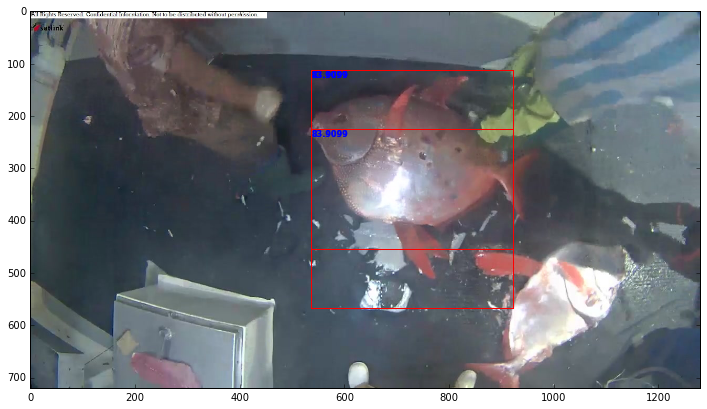

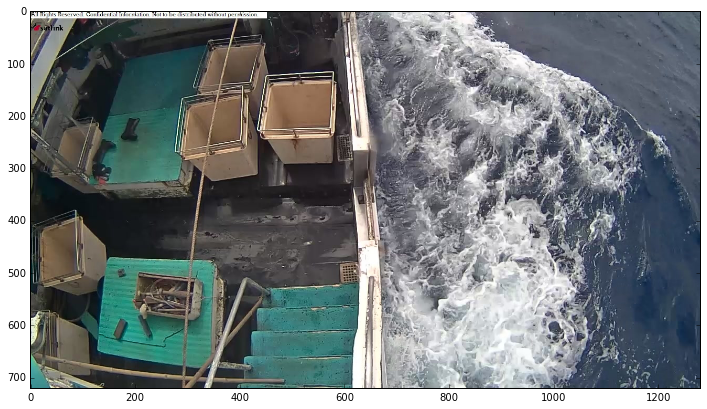

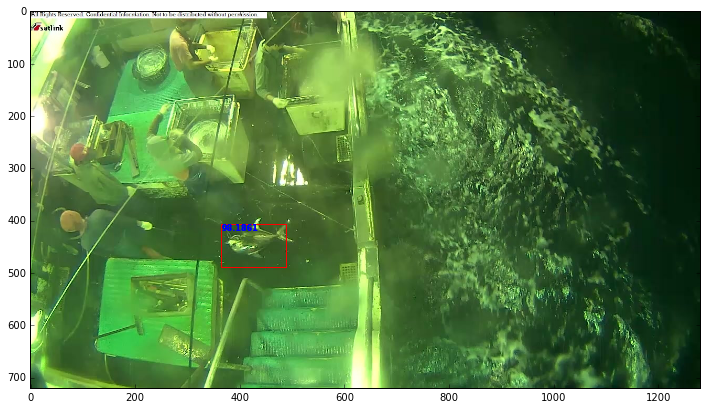

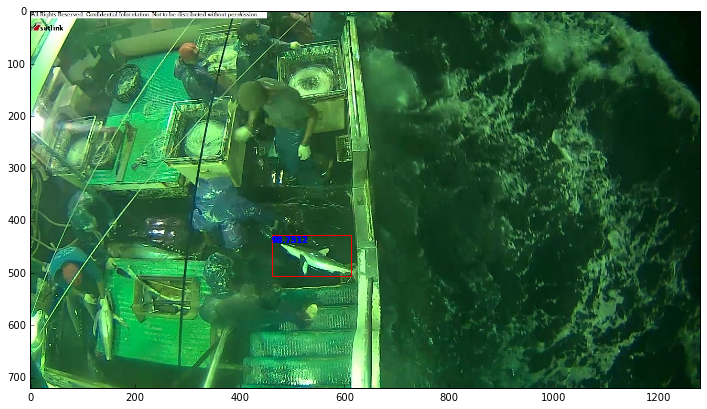

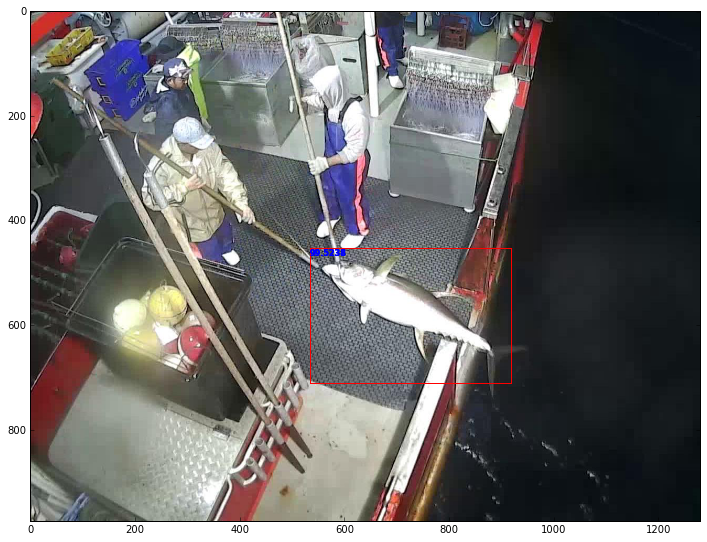

In [9]:
for i in range(len(images_train)):
    image = images_train[i]
    bboxes = bboxes_fish[i]
    
    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
    ax.imshow(image.astype('uint8'))
    for idx in range(len(bboxes)):
        bbox = bboxes[idx]
        x, y, w, h, p = bbox[:]
        rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.annotate(str(p), (x, y), color='b', weight='bold', fontsize=8, ha='left', va='top')
        ax.add_patch(rect)
    plt.show()

## Save BBox Images with/out Fish

In [46]:
import shutil, os


fish_bbox_dir = os.path.join(file_dir_path, '../datasets/fish_dataset/fish/')
nofish_bbox_dir = os.path.join(file_dir_path, '../datasets/fish_dataset/nofish/')


# createdir
if os.path.isdir(fish_bbox_dir):
    shutil.rmtree(fish_bbox_dir)
if os.path.isdir(nofish_bbox_dir):
    shutil.rmtree(nofish_bbox_dir)
os.mkdir(fish_bbox_dir)
os.mkdir(nofish_bbox_dir)

In [47]:
# save image
fish_img_idx = 0
nofish_img_idx = 0
for i in range(len(images_train)):
    
    if i % 200 == 0:
        print("%s/%s"%(i, len(images_train)))
    
    image = images_train[i]
    fish_bboxes = bboxes_fish[i]
    nofish_bboxes = bboxes_nofish[i]
    
    # save fish image
    for bbox in fish_bboxes:
        x, y, w, h, p = bbox
        x, y, w, h = int(x), int(y), int(w), int(h)
        fish_img = image[y: y+h, x : x+w].astype('uint8')
        img_url = os.path.join(fish_bbox_dir, "%s.png"%(fish_img_idx))
        plt.imsave(img_url, fish_img)
        fish_img_idx += 1
    
    # save nofish image
    for bbox in nofish_bboxes:
        x, y, w, h, p = bbox
        fish_img = image[y: y+h, x : x+w].astype('uint8')
        img_url = os.path.join(nofish_bbox_dir, "%s.png"%(nofish_img_idx))
        plt.imsave(img_url, fish_img)
        nofish_img_idx += 1

print("Total number of fish image is %s"%(fish_img_idx))
print("Total number of nofish image is %s"%(nofish_img_idx))

Total number of fish image is 38
Total number of nofish image is 2755


/Users/liuweijie/WorkSpace/NFCM_Classification/.env/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
